# Binary star evolution and binary black holes

Giacomo Menegatti, Dario Puggioni, Laura Schulze, Savina Tsichli

## Introduction


The discovery of gravitational waves in 2015 marked a significant breakthrough, offering new insights into the physics and astrophysics of compact celestial objects. Since then, numerous gravitational wave events have been observed, predominantly attributed to the merging of two black holes (BHs). Finding out more about these systems is crucial, as they provide us with information about the evolution and formation of **Binary Black Holes (BBHs)** , which usually originate from a binary star system.

Throughout this system’s lifespan, a closely orbiting pair of massive stars experiences a series of complex physical transformations that change its final state. These include the exchange of mass between the two stars, which can occur through:
- **Stable Mass Transfer (SMT)** , or
- **Common Envelope (CE)**

These interactions significantly affect the eventual masses and orbital characteristics of the resulting binary black hole system.

Initially, the two stars are both on the main sequence (MS). When the most massive one leaves the MS, its radius starts inflating and can grow dramatically. 

**Stable Mass Transfers** happen mainly due to Roche-lobe filling, but stellar winds may also be the cause; if the massive star’s radius equals the Roche lobe, the system starts the SMT episode. Roche-lobes are regions surrounding the stars that are determined by the gravitational interaction between two stars; their shape resembles a teardrop with the apex pointing towards the companion star. When a star expands beyond its Roche-lobe, material can start flowing towards its companion star due to gravitational forces causing the mass transfer. 

<div>
<center><img src="Picture4.png" width="550"/></center>
</div>


Some mass is lost from the system while some is transferred to the companion star. 

However, if both stars fill their Roche-lobe (when the secondary star also leaves the MS) or Mass Transfer is dynamically unstable, then the binary system is expected to merge via **Common Envelope (CM)**. Their outer envelopes cease to rotate synchronously with their cores and this results in both stellar cores being enveloped by the same non-rotating outer layer. Consequently, they begin spiraling inward due to the drag exerted by the envelope. As this happens, a portion of their orbital energy is dissipated causing the heating of the envelope and making it less tightly bound; this may lead to the ejection of the envelope. This way the binary survives, and it is composed of two naked stellar cores; if the two cores evolve into a BBH system, it will have a short semi-major axis (much smaller than the sum of the maximum radii of its progenitor stars).

<div>
<center><img src="Picture1.png" width="550"/></center>
</div>


The most common way to describe a Common Envelope is the **α** formalism; the energy required to expel the envelope originates solely from the loss of orbital energy during the spiral in of the two cores. α is a dimensionless parameter that measures this loss of energy; the larger the α, the more easily ejected the envelope is and vice versa.
In this notebook, the simulated systems used can have values of α>1. This happens because this simple formalism poorly describes the physics of Common Envelope as these interactions are much more complex. A comprehensive treatment of CE must consider various additional factors beyond just the orbital energy of the cores and the binding energy of the envelope.

<div>
<center><img src="Picture3.png" width='300'/></center>    
</div>

For this reason, in this project the characteristics of these systems will be analyzed. 
This project aims to differentiate binary black hole systems that evolved via stable mass transfer from those who evolved via common envelop by investigating simulation data. In each dataset of the simulated data, systems which underwent common envelope are marked with "True" and systems which underwent stable mass transfer are marked with "False" in the "CE" parameter. The data are analyzed to identify the features with the highest impact on the evolution of the binary system regarding mass transfer and common envelope. For this purpose, the biserial correlation as well as the parameter importances in a machine learning model are investigated.

In [10]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import regex as re
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

## Loading the dataset
The dataset is divided in files depending on the CE efficiency $ \alpha $ and the metallicity $ Z $ of the two stars. All the data are loaded into a pandas dataframe containing also the two parameters. The following table contains the parameter names, units and descriptions.


| Column name | Unit | Parameter description |
|------|------|------|
| m1ZAMS | $M_\odot$ | zero-age main sequence mass of the primary member of the binary system |
| m2ZAMS | $M_\odot$ | zero-age main sequence mass of the secondary member of the binary system |
| m1rem | $M_\odot$ | mass of the black hole that forms from the primary member |
| m2rem | $M_\odot$ | mass of the black hole that forms from the secondary member |
| m1rem+m2rem | $M_\odot$ |  sum of the masses of the two black holes |
| delay_time | Myr | delay time |
| sma | $R_\odot$ | semi-major axis of the binary system at the formation of the second-born black hole |
| ecc | - | orbital eccentricity of the binary system at the formation of the second-born black hole | kick_1 | km/a | magnitude of the supernova kick associated with the primary member |
| kick_1 | km/s | magnitude of the supernova kick associated with the primary member |
| kick_2 | km/s | magnitude of the supernova kick associated with the secondary member |
| cmu1 | - | cosine of the tilt angle between the orbital angular momentum of the binary system before and after the supernova explosion of the primary member |
| cmu2 | - | cosine of the tilt angle between the orbital angular momentum of the binary system before and after the supernova explosion of the secondary member |
| time_SN1 | Myr | time at which the primary component undergoes a supernova |
| time_SN2 | Myr | time at which the secondary component undergoes a supernova |
| CE | - | Boolean variable indicating whether the binary system undergoes a common envelope (True) |
| alpha | - | efficiency parameter of common envelope |
| Z | - | stellar metallicity at which the black holes were produced |

In [11]:
alpha = [0.5, 1, 3, 5] # CE efficiency
Z = [2e-4, 4e-4, 8e-4, 1.2e-3, 1.6e-3, 2e-3, 4e-3, 6e-3, 8e-3, 1.2e-2, 1.6e-2, 2e-2]  #Metallicity value

data = [] #Data list

sim_data = pd.DataFrame({'alpha':[], 'Z':[], 'MtotZAMS':[], 'num_mergers':[]})
#Appending all the values in a single big dataframe

index = 0
for a in alpha:
    for m in Z:
        # The simulation data first row contains the MtotZAMS and the number of merger for each alpha and metallicity
        df = pd.read_csv(f'stable_MT_vs_CE/A{a}/MTCE_BBHs_{m}.txt', sep=' ', nrows = 1, header=0)
        sim_data.loc[index] = [a, m, df.iloc[0,0], df.iloc[0,1]]  #Adding the row to the sim_data df
        index = index + 1

        df = pd.read_csv(f'stable_MT_vs_CE/A{a}/MTCE_BBHs_{m}.txt', header=2, sep= ' ')     # Simulation data
        df['alpha'],df['Z'] = a, m                                 #Adding the alpha and Z paramtere in the table

        data.append(df)

data = pd.concat(data)
data.columns = [re.sub('col.*:|/.*$', '', name) for name in data.columns]

# separate the kick columns
data.columns.values[9] = 'kick_1'
data.columns.values[10] = 'kick_2'

# switch vx and kick columns
data["kick_1"], data["v1x"] =  data["v1x"], data["kick_1"]
data["kick_2"], data["v2x"] =  data["v2x"], data["kick_2"]

# Drop the ID column
data = data.drop(columns=["ID","v1x","v1y","v1z","v2x","v2y","v2z"]) #We drop velocities due to 
#instructions given by prof. Iorio

print('Data columns: \n ', data.columns.values)
data.reset_index(drop=True,inplace=True)
data


Data columns: 
  ['m1ZAMS' 'm2ZAMS' 'm1rem' 'm2rem' 'm1rem+m2rem' 'delay_time' 'sma' 'ecc'
 'kick_1' 'kick_2' 'cmu1' 'cmu2' 'time_SN1' 'time_SN2' 'CE' 'alpha' 'Z']


,m1ZAMS,m2ZAMS,m1rem,m2rem,m1rem+m2rem,delay_time,sma,ecc,kick_1,kick_2,cmu1,cmu2,time_SN1,time_SN2,CE,alpha,Z
0,24.1323,17.1893,9.5692,5.0020,14.5712,141.1783,5.1703,0.258940,10.340,159.00,0.9506,0.9988,8.826,13.340,True,0.5,0.0002
1,69.5474,64.3689,28.4847,39.1186,67.6033,9.2023,6.4328,0.055966,1.263,33.43,1.0000,1.0000,4.270,5.594,True,0.5,0.0002
2,106.6977,41.0318,39.9392,38.2094,78.1486,2223.2639,35.8880,0.041435,14.120,13.65,1.0000,1.0000,3.722,6.271,False,0.5,0.0002
3,74.3594,54.3256,30.1523,37.4020,67.5543,8.7628,6.0720,0.041342,1.621,26.89,1.0000,1.0000,4.163,5.917,True,0.5,0.0002
4,116.6000,63.2642,41.9604,42.9817,84.9421,2636.2197,40.0410,0.079504,14.000,25.05,1.0000,1.0000,3.645,5.581,False,0.5,0.0002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2963577,49.5343,41.7016,4.9807,4.6760,9.6567,10772.9297,11.8280,0.251980,105.800,106.80,0.9965,0.9998,4.938,5.526,True,5.0,0.0200
2963578,89.2801,62.1861,7.3304,5.1195,12.4499,16.0614,462.4200,0.999370,10.970,31.54,0.9616,0.9626,4.100,4.566,True,5.0,0.0200
2963579,36.4361,27.1551,4.0565,3.2400,7.2965,2200.2712,212.1500,0.993170,4.844,57.32,0.8033,0.5281,5.870,8.173,True,5.0,0.0200
2963580,73.1220,37.7591,8.2607,4.8831,13.1438,6547.9141,302.6300,0.988970,2.550,40.58,0.9967,0.0059,4.282,6.396,True,5.0,0.0200


In [12]:
N_data = data.shape[0]

CE_data = data.query('CE == True').shape[0]
MT_data = data.query('CE == False').shape[0]
print(f'There are {CE_data} ({CE_data/N_data * 100:.2f}%) BBHs evolving from common envelope, and {MT_data} ({MT_data/N_data * 100:.2f}%) BBHs evolving from mass transfer, for a total of {N_data} BBHs')


There are 2551001 (86.08%) BBHs evolving from common envelope, and 412581 (13.92%) BBHs evolving from mass transfer, for a total of 2963582 BBHs


### Analyzing the correlation between parameters
Before assessing the importance of features, we examinate the correlation between features themselves. It is anticipated that stronger correlations between features might affect how their importance is evaluated.

Here, we examine the Spearman correlation between the features. For visualization purposes, only the upper diagonal part of the matrices is used.

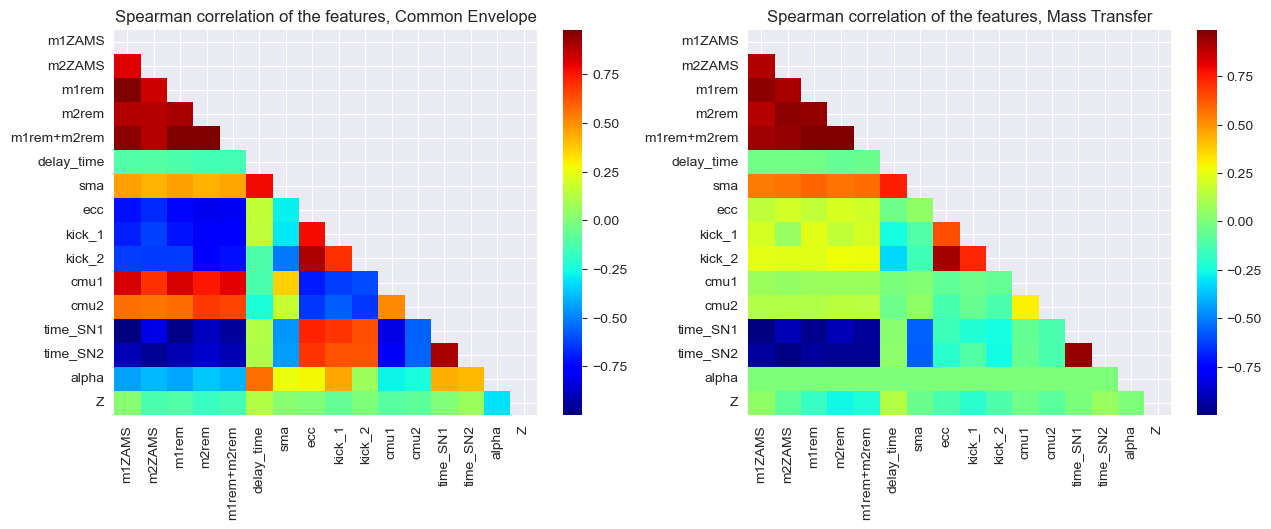

In [13]:
data_corr_CE = data.query('CE==True').drop(columns='CE')
data_corr_MT = data.query('CE==False').drop(columns='CE')

fig,axs=plt.subplots(1,2,figsize=(15,5))

corr_matrix_CE = data_corr_CE.corr(method='spearman')
mask = np.triu(np.ones_like(corr_matrix_CE, dtype=bool))
sns.heatmap((corr_matrix_CE), mask=mask, cmap='jet', linecolor='w',ax=axs[0])
axs[0].set_title('Spearman correlation of the features, Common Envelope')

corr_matrix_MT = data_corr_MT.corr(method='spearman')
mask = np.triu(np.ones_like(corr_matrix_MT, dtype=bool))
sns.heatmap((corr_matrix_MT), mask=mask, cmap='jet', linecolor='w',ax=axs[1])
axs[1].set_title('Spearman correlation of the features, Mass Transfer')
plt.show()


By looking at the heatmaps above we notice that the most correlated parameters are the masses and the time of supernova explosions, as well as the kick velocities and the eccentricities. More specifically, for the Common Envelope we notice that the features of eccentricity and kick velocities are strongly correlated with the cosine of the tilt angle, while this does not seem to happen for the Mass Transfer case. Finally, alpha is a parameter that only affects Common Envelope, therefore it is not correlated to any other parameters in the case of Mass Transfer.

## Investigating biserial correlation of the parameters

In this section the point biserial correlation is calculated for each feature with respect to the binary parameter "CE". In the following table the values can range from -1 to 1 and indicate the grade of correlation between data and a binary condition.

We expect that the more strongly correlated data will be the most useful in our analysis.

In [14]:
numeric_columns = data.drop(columns="CE")
correlation_dict = {}
for column in numeric_columns:
    correlation = data[column].corr(data['CE'])
    correlation_dict[column] = correlation
correlation_df=pd.DataFrame(correlation_dict,index=['Correlation']).T
correlation_df.sort_values(by='Correlation',key=abs,ascending=False)


,Correlation
m1ZAMS,-0.462425
m1rem,-0.450506
time_SN1,0.396096
m1rem+m2rem,-0.383408
m2rem,-0.306382
time_SN2,0.251870
delay_time,-0.220924
ecc,0.215878
kick_2,0.189565
kick_1,0.084345


Histograms of the data for each features are shown, plotting them with a different color for the binary condition "CE". They are normalized to better visualize two datasets that had different amounts of data in the same plot. Furthermore, for some of these histograms a logarithmic scale is used for the counts.

C:\Users\savin\AppData\Local\Temp\ipykernel_6516\1420047127.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_CE, rotation=45)
C:\Users\savin\AppData\Local\Temp\ipykernel_6516\1420047127.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_CE, rotation=45)


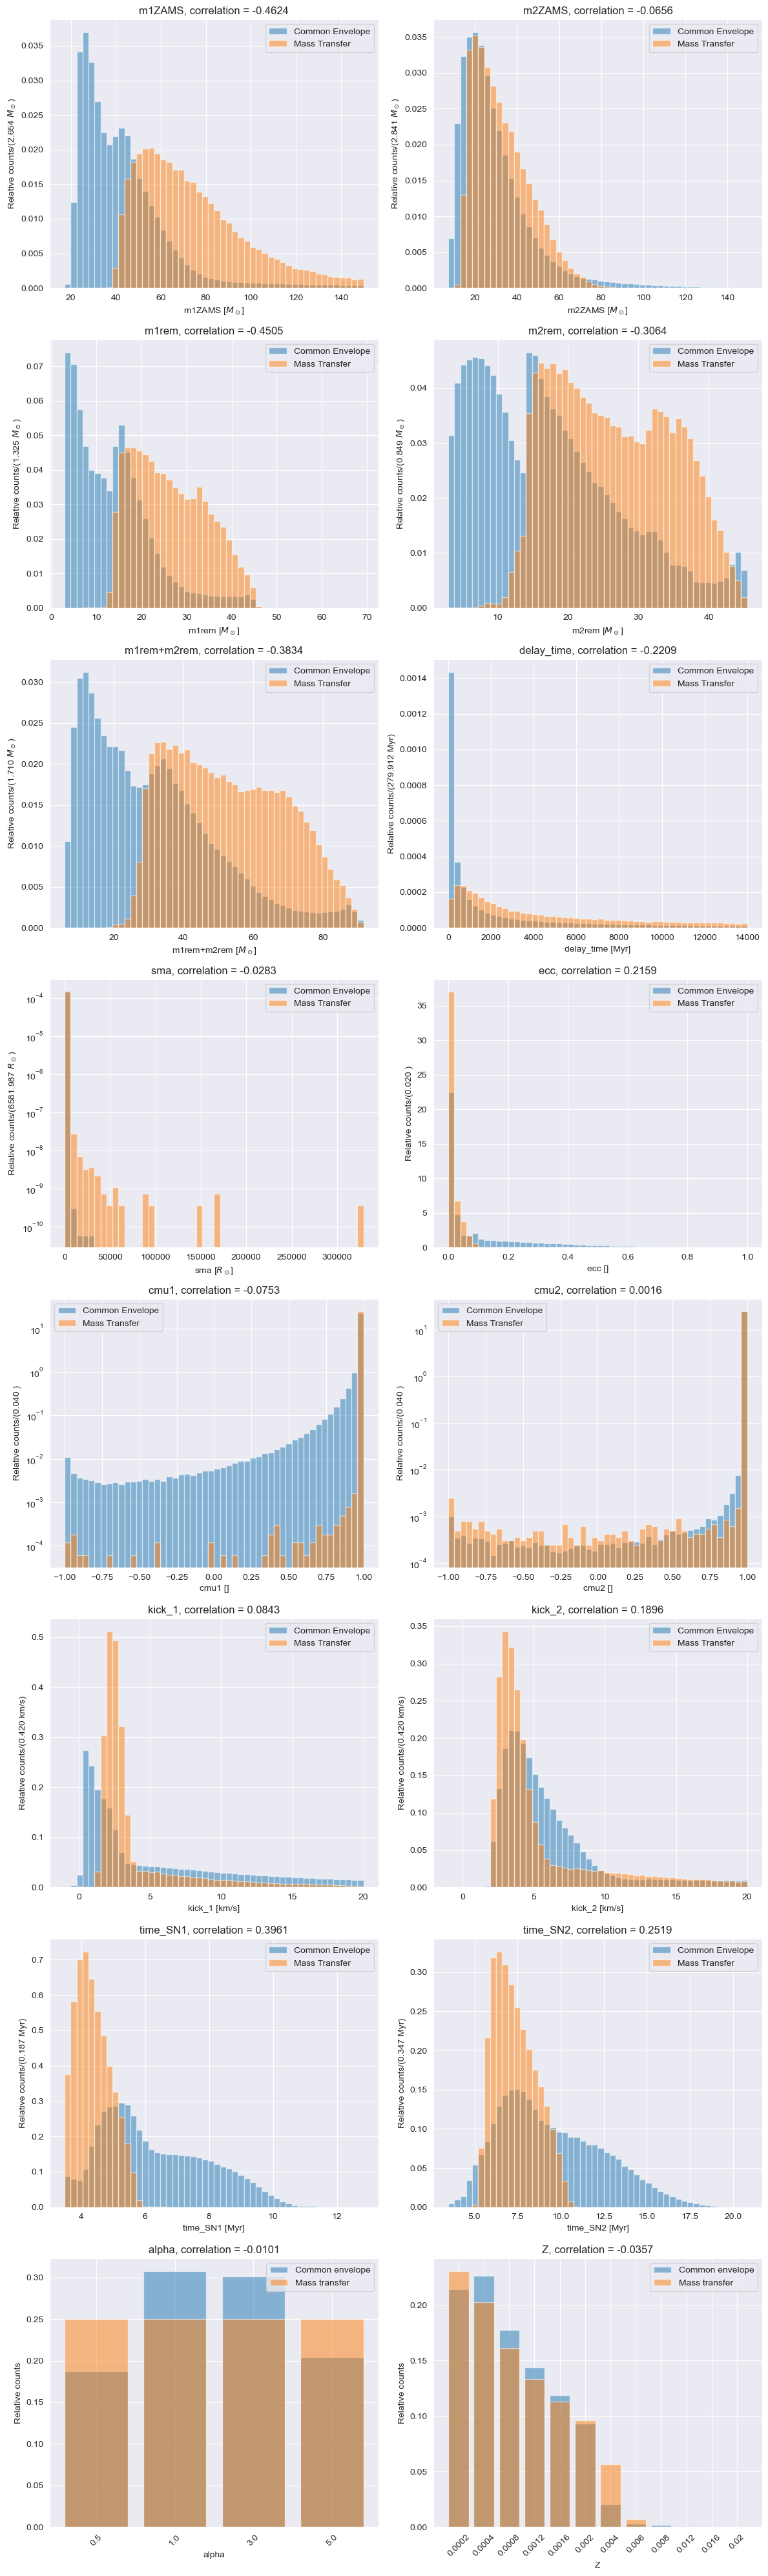

In [21]:
# Function to plot the parameters (only for continue distributions)
def plot_continue(ax, feature, uom='', bins = 50, hist_range=None, log=False):
    if hist_range == None:
        hist_range = (data[feature].min(), data[feature].max())
    bin_width = (hist_range[1]-hist_range[0])/bins
    data[data.CE == True][feature].hist(bins = bins, range = hist_range, alpha=0.5, label='Common Envelope', ax=ax,density=True, log=log)
    data[data.CE == False][feature].hist(bins = bins, range = hist_range, alpha=0.5, label='Mass Transfer', ax=ax,density=True, log=log)
    ax.legend(loc='best')
    ax.set_xlabel(f'{feature} [{uom}]')
    ax.set_ylabel(f'Relative counts/({bin_width:.3f} {uom})')
    ax.set_title(f'{feature}, correlation = {correlation_dict[feature]:.4f}')
    return ax

def plot_discrete(ax, feature):
    # Function to plot a discrete variable

    labels_CE, counts_CE = np.unique(data[data['CE'] == True][feature], return_counts= True)
    # Making the labels strings so they are equally spaced on the plot
    labels_CE = [str(x) for x in labels_CE]
    ax.set_xticklabels(labels_CE, rotation=45)
    labels_MT, counts_MT = np.unique(data[data['CE'] == False][feature], return_counts= True)
    labels_MT = [str(x) for x in labels_CE]
    ax.bar(labels_CE, counts_CE/CE_data, alpha=0.5,label='Common envelope')
    ax.bar(labels_MT, counts_MT/MT_data, alpha=0.5,label='Mass transfer')
    ax.set_ylabel(f'Relative counts')
    ax.set_xlabel(f'{feature}')
    ax.set_title(f'{feature}, correlation = {correlation_dict[feature]:.4f}')
    ax.legend(loc='best')
    return ax


fig, axs = plt.subplots(nrows=8, ncols=2, figsize=(12, 40))

ax = plot_continue(axs[0,0], 'm1ZAMS', '$M_\odot$')
ax = plot_continue(axs[0,1], 'm2ZAMS', '$M_\odot$')
ax = plot_continue(axs[1,0], 'm1rem', '$M_\odot$')
ax = plot_continue(axs[1,1], 'm2rem', '$M_\odot$')
ax = plot_continue(axs[2,0], 'm1rem+m2rem', '$M_\odot$')
ax = plot_continue(axs[2,1], 'delay_time', 'Myr')
ax = plot_continue(axs[3,0], 'sma', '$R_\odot$', log=True)
ax = plot_continue(axs[3,1], 'ecc', '')
ax = plot_continue(axs[4,0], 'cmu1', '', log=True)
ax = plot_continue(axs[4,1], 'cmu2', '', log=True)
ax = plot_continue(axs[5,0], 'kick_1', 'km/s', hist_range=(-1, 20))
ax = plot_continue(axs[5,1], 'kick_2', 'km/s', hist_range=(-1,20))
#ax = plot_continue(axs[6,0], 'v1x', 'km/s', log=True)
#ax = plot_continue(axs[6,1], 'v2x', 'km/s', log=True)
#ax = plot_continue(axs[7,0], 'v1y', 'km/s',  log=True)
#ax = plot_continue(axs[7,1], 'v2y', 'km/s',  log=True)
#ax = plot_continue(axs[8,0], 'v1z', 'km/s', log=True)
#ax = plot_continue(axs[8,1], 'v2z', 'km/s', log=True)
ax = plot_continue(axs[6,0], 'time_SN1', 'Myr')
ax = plot_continue(axs[6,1], 'time_SN2', 'Myr')

#Plotting alpha and Z

ax = plot_discrete(axs[7,0], 'alpha')
ax = plot_discrete(axs[7,1], 'Z')

plt.tight_layout()
plt.show()


## Investigating parameter importance through Machine Learning
In the following section, the importance of the parameters is examined further by evaluating a machine learning model.
First, a Random Forest model is trained on the simulation data to predict whether a system evolves via common envelope or not. Then, the impact of the different parameters on the model and its prediction accuracy is investigated.

### Training the Random Forest Model
The Random Forest was implemented using the `RandomForestClassifier` from the sklearn.ensemble module. As per default, the Random Forest consists of 100 decision trees. 

We implement this algorithm twice, once with the original data and once adding a simulated feature using Gaussian distribution; that does not add information to the data, but it helps setting a lower limit to the importances: if a feature has a similar importance to the random simulated one, it means it is not important. This has been done because the Gini importance is biased towards high cardinality data.

Random Forest algorithm is trained using a 10%-subset of the simulation data, and the prediction accuracy is tested using the remaining 90% of the data. A test of approx. 99.8% accuracy is achieved.

In [23]:
# prepare data X and labels y
X = data.drop(columns='CE')
y = data['CE']

# split data into training and test set (10% to 90%)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.9, random_state=100)


In [24]:
# initialise random forest classifier
# using n_jobs=-1 to run parallel jobs using all processors
clf = RandomForestClassifier(random_state=0, n_jobs=-1)

# train random forest
# time the process
ts = time.time()
clf.fit(X_train, y_train)
print("Training time: %.2f s"%(time.time()-ts))

# evaluate training & test accuracy
train_acc = clf.score(X_train, y_train)
test_acc = clf.score(X_test, y_test)
print("Training accuracy: ", train_acc)
print("Test accuracy: ", test_acc)


Training time: 48.48 s
Training accuracy:  1.0
Test accuracy:  0.9984770682927269


In [25]:
X_noise = X.copy()
X_noise['noise'] = np.random.normal(0, 1, size = N_data)

# split data into training and test set (10% to 90%)
X_train_noisy, X_test_noisy, y_train_n, y_test_n = train_test_split(X_noise, y, stratify=y, test_size=0.9, random_state=100)

# initialise random forest classifier
# using n_jobs=-1 to run parallel jobs using all processors
clf_noisy = RandomForestClassifier(random_state=0, n_jobs=-1)

# train random forest
# time the process
ts = time.time()
clf_noisy.fit(X_train_noisy, y_train)
print("Training time: %.2f s"%(time.time()-ts))

# evaluate training & test accuracy
train_acc_n = clf_noisy.score(X_train_noisy, y_train)
test_acc_n = clf_noisy.score(X_test_noisy, y_test)
print("Training accuracy: ", train_acc_n)
print("Test accuracy: ", test_acc_n)

Training time: 50.80 s
Training accuracy:  1.0
Test accuracy:  0.9984669454084096


In [26]:
from sklearn import metrics

def show_confusion_matrix(validations, predictions,axes,perc=False):

    matrix = metrics.confusion_matrix(validations, predictions)
    #plt.figure(figsize=(6, 5))
    M = matrix
    f = 'd'
    cmap="GnBu"
    if perc:
        M=M/np.sum(M)
        f='.2%'
        cmap='Blues'
    sns.heatmap(M, annot=True, fmt=f, linecolor='white', linewidths=1, cmap=cmap,ax=axes)
    #plt.title('Confusion Matrix')
    axes.set_ylabel('True Label')
    axes.set_xlabel('Predicted Label')
    #plt.show()

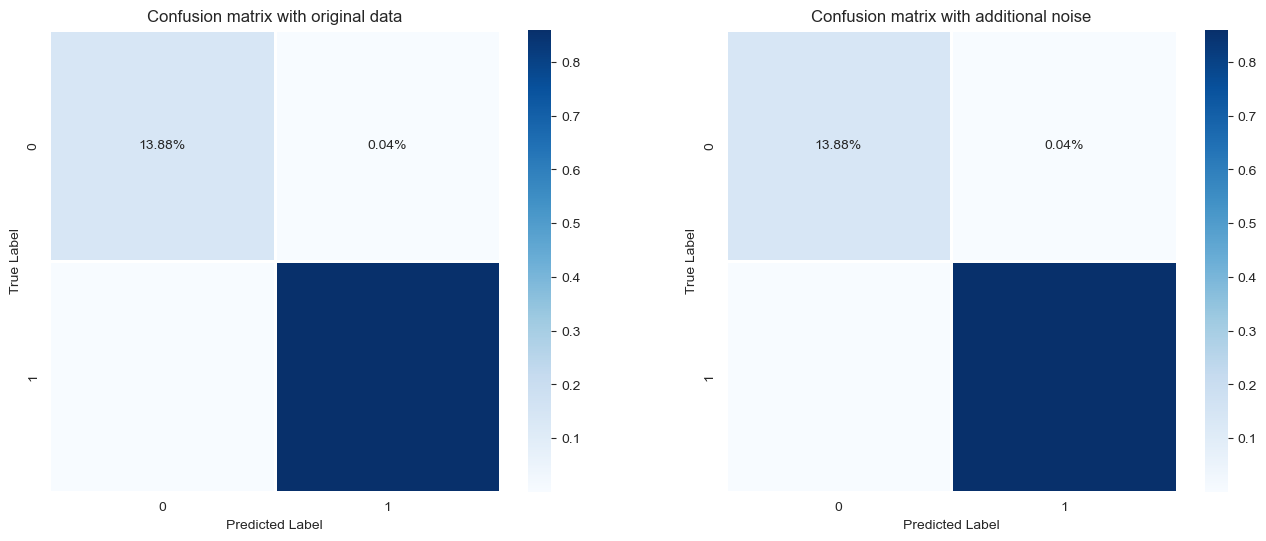

In [27]:
fig,ax=plt.subplots(1,2,figsize=(16,6))

show_confusion_matrix(y_test, clf.predict(X_test), ax[0], perc=True)
show_confusion_matrix(y_test_n, clf_noisy.predict(X_test_noisy), ax[1], perc=True)
ax[0].set_title('Confusion matrix with original data')
ax[1].set_title('Confusion matrix with additional noise')
plt.show()

As can be seen from the Confusion matrices, adding random noise does not seem to affect the performances of the algorithms. For that reason, it will not be used in the following analysis.

### Analyzing feature importance
After training a model that predicts with a satisfactory accuracy, the importance of the features is evaluated using two different metrics; the Gini importance and the Permutation importance.
The Gini importance is based on the decrease in impurity, whereas the permutation importance is based on the mean decrease in accuracy.

#### Gini importance
The Gini importance of a feature is estimated through the weighted impurity decrease at the nodes where the feature is used to split samples in the decision trees. In scikit-learn, the Gini importances are available through the `feature_importances_`-attribute of the `RandomForestClassifier`.

In [28]:
clf.feature_importances_

array([0.07926024, 0.14959173, 0.10100665, 0.0365222 , 0.03649323,
       0.03246298, 0.10776221, 0.03632062, 0.14087687, 0.03047113,
       0.0087265 , 0.00052332, 0.10964673, 0.0987483 , 0.01927359,
       0.01231371])

AttributeError: 'RandomForestClassifier' object has no attribute 'bar'

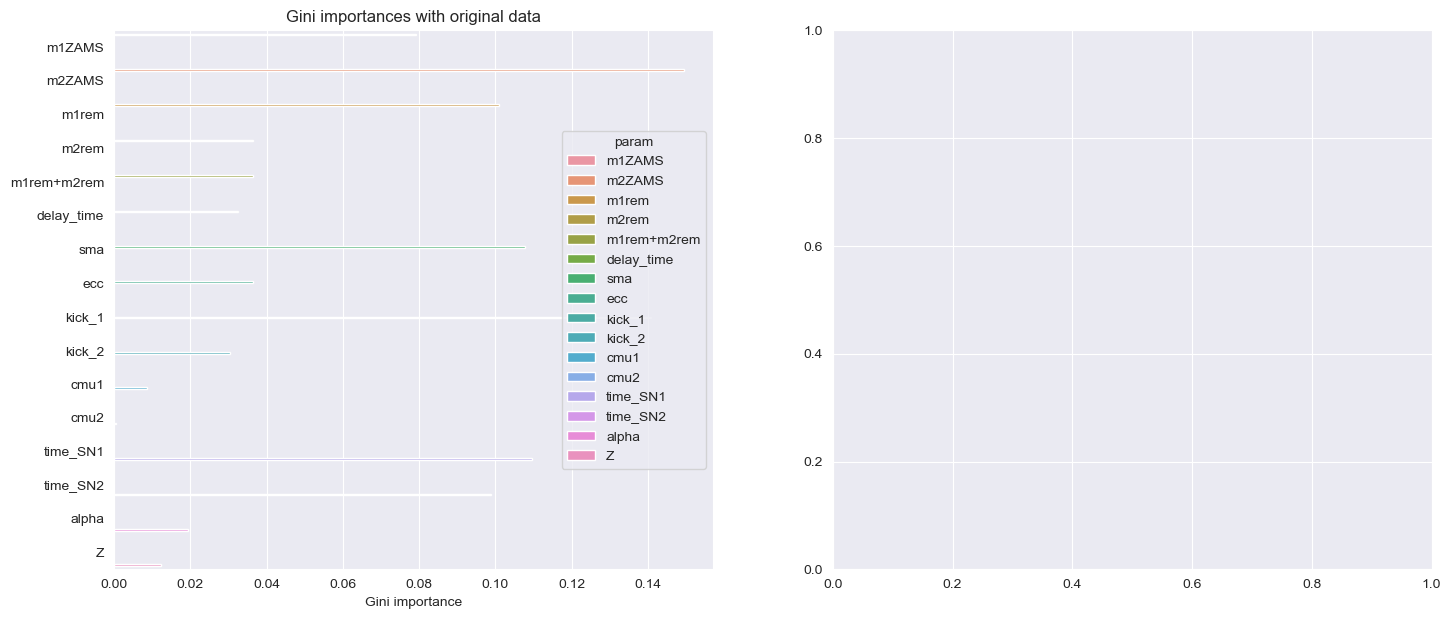

In [29]:
# save params + importances to dataframe
importances = pd.DataFrame(zip(clf.feature_names_in_, clf.feature_importances_),columns=["param", "gini"])
importances_noisy = pd.DataFrame(zip(clf_noisy.feature_names_in_, clf_noisy.feature_importances_),columns=["param", "gini"])

# plot Gini importances
fig, ax = plt.subplots(1,2,figsize=(17,7))
sns.barplot(y='param', x='gini', data=importances, ax=ax[0], hue='param')
ax[0].set_ylabel('')
ax[0].set_xlabel('Gini importance')
ax[0].set_title('Gini importances with original data')


clrs = ['r' if (param == 'noise') else 'b' for param in clf_noisy.feature_names_in_]
sns.barplot(y='param', x='gini', data=importances_noisy, ax=ax[1], hue='param',xerr=clf_noisy.bar)
ax[1].set_ylabel('')
ax[1].set_xlabel('Gini importance with noisy channels')
ax[1].set_title('Gini importances with additional noise')
forest_importances.plot.bar(xerr=std, ax=ax[1])

plt.tight_layout(h_pad=1)
plt.show()

As expected, the importance of the features are nearly unchanged with or without the addition of an extra column of noise. You can notice that cmu2 has an importance even lower than the noise, so it is not important at all.

#### Permutation Feature Importance
The permutation importance of a feature describes the mean decrease in accuracy when the values of that feature are randomly permutated, and is computed using out-of-bag samples. Here, the permutation feature importances were calculated with the test data set using the `sklearn.inspection.permutation_importance` method.

As the computation of the permutation importance using the entire test set takes a lot of time, a subset corresponding to 10% of the total data was chosen from the test set. Furthermore, the number of repetitions `n_repeats` was set to 5 to limit the computation time as well.

In [115]:
# compute permutation feature importances
# warning: takes a lot of time to compute!
ts = time.time()
result = permutation_importance(clf, X_test[::10], y_test[::10], n_repeats=5, random_state=0, n_jobs=-1)
print("importance calculation time: {:.2f} s".format(time.time() - ts))
# save importances to DataFrame
importances['permutation'] = result.importances_mean
importances_stds = result.importances_std


importance calculation time: 61.81 s


In [ ]:
# plot permutation importances
fig, ax = plt.subplots()
sns.barplot(y='param', x='permutation', data=importances, ax=ax, hue='param')
ax.set_ylabel('')
ax.set_xlabel('Permutation feature importance')
fig.tight_layout()
plt.show()

In [114]:
importances

,param,gini
0,m1ZAMS,0.079260
1,m2ZAMS,0.149592
2,m1rem,0.101007
3,m2rem,0.036522
4,m1rem+m2rem,0.036493
5,delay_time,0.032463
6,sma,0.107762
7,ecc,0.036321
8,kick_1,0.140877
9,kick_2,0.030471


## Comparison of feature importances

After investigating the biserial correlation, the Gini importance and the permutation importance, the obtained results are now compared.

The following table highlights the 5 highest absolute values in each of the importance measures.

In [70]:
# add biserial correlation
importances["biserial"] = correlation_df["Correlation"].values

# highlight 5 highest importances in each column
styled_importances = (importances
                      .style
                      .apply(lambda col: ['background-color: skyblue' if (col.dtype==float and abs(val) in col.abs().nlargest(5).values) else '' for val in col],
                             axis=0))

# Visualizzare il DataFrame con lo stile applicato
styled_importances


,param,gini,permutation,biserial
0,m1ZAMS,0.079260,0.011416,-0.462425
1,m2ZAMS,0.149592,0.034173,-0.065608
2,m1rem,0.101007,0.094314,-0.450506
3,m2rem,0.036522,0.009658,-0.306382
4,m1rem+m2rem,0.036493,0.004055,-0.383408
5,delay_time,0.032463,0.000440,-0.220924
6,sma,0.107762,0.012571,-0.028308
7,ecc,0.036321,0.004732,0.215878
8,kick_1,0.140877,0.036120,0.084345
9,kick_2,0.030471,0.000477,0.189565


In order to compare the importances more easily, each importance measure is normalized so that the absolute values summed over all features add up to one. The Gini importance is normalized this way per default; permutation importance and biserial correlation were adjusted accordingly, even if biserial correlation is not proper measure for compare features, but it´s useful for single feature.

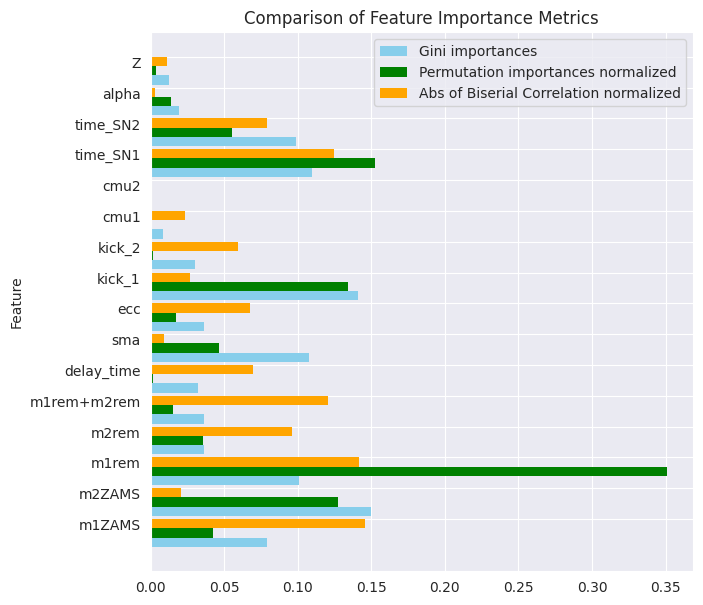

In [74]:
# plotting the normalized importances
bar_width = 0.3
fig, ax = plt.subplots(figsize=(7, 7))

index = np.arange(len(correlation_df))

ax.barh(index, importances['gini'], color='skyblue', height=bar_width, label='Gini importances',edgecolor='none')
ax.barh(index + bar_width, np.abs(importances['permutation'])/np.abs(importances['permutation']).sum(), color='green', height=bar_width, label='Permutation importances normalized',edgecolor='none')
ax.barh(index+2*bar_width, np.abs(correlation_df.iloc[:,0])/np.abs(correlation_df.iloc[:,0]).sum(), color='orange', height=bar_width, label='Abs of Biserial Correlation normalized',edgecolor='none')

ax.set_yticks(index+5/2*bar_width)
ax.set_yticklabels(correlation_df.index, va='top')

ax.set_ylabel('Feature')
ax.set_title('Comparison of Feature Importance Metrics')

ax.legend()
plt.show()

In the three metrics are used the permutation one shows a more marked separation in the importance of the features: the m1rem is the most pronounced feature; the other metrics do not emphasize this but they not totally disagree: looking at the table above (and the figure above) we see parameters are highlighted at least twice, if not they are not however the most important of the metric. We can anyway consider the permutation the most reliable metric because it´s the one which randomizes more data, it´s not biased (unlike the Gini importance).

## Reduced Data Set

The importance assessment is repeated with a reduced data set. This data set contains the parameters that were suggested to be important and marked as bold in the project assignment. The methods are exactly the same as the ones used for the full data set.

In [18]:
data_reduced = data[["m1ZAMS", "m2ZAMS", "m1rem", "m2rem", "delay_time", "sma", "ecc", "alpha", "Z"]]
data_reduced

,m1ZAMS,m2ZAMS,m1rem,m2rem,delay_time,sma,ecc,alpha,Z
0,24.1323,17.1893,9.5692,5.0020,141.1783,5.1703,0.258940,0.5,0.0002
1,69.5474,64.3689,28.4847,39.1186,9.2023,6.4328,0.055966,0.5,0.0002
2,106.6977,41.0318,39.9392,38.2094,2223.2639,35.8880,0.041435,0.5,0.0002
3,74.3594,54.3256,30.1523,37.4020,8.7628,6.0720,0.041342,0.5,0.0002
4,116.6000,63.2642,41.9604,42.9817,2636.2197,40.0410,0.079504,0.5,0.0002
...,...,...,...,...,...,...,...,...,...
2963577,49.5343,41.7016,4.9807,4.6760,10772.9297,11.8280,0.251980,5.0,0.0200
2963578,89.2801,62.1861,7.3304,5.1195,16.0614,462.4200,0.999370,5.0,0.0200
2963579,36.4361,27.1551,4.0565,3.2400,2200.2712,212.1500,0.993170,5.0,0.0200
2963580,73.1220,37.7591,8.2607,4.8831,6547.9141,302.6300,0.988970,5.0,0.0200


Splitting the reduced data set:

In [19]:
X = data_reduced
y = data["CE"]

# split data into training and test set (10% to 90%)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.9, random_state=100)

Initialising and training the Random Forest model:

In [20]:
# initialise random forest classifier
# using n_jobs=-1 to run parallel jobs using all processors
clf = RandomForestClassifier(random_state=0, n_jobs=-1)

# train random forest
# time the process
ts = time.time()
clf.fit(X_train, y_train)
print("Training time: %.2f s"%(time.time()-ts))

# evaluate training & test accuracy
train_acc = clf.score(X_train, y_train)
test_acc = clf.score(X_test, y_test)
print("Training accuracy: ", train_acc)
print("Test accuracy: ", test_acc)

Training time: 25.12 s
Training accuracy:  1.0
Test accuracy:  0.997928183009751


Assessing the Gini and permutation importances:

In [21]:
# save params + importances to dataframe
importances_reduced = pd.DataFrame(zip(clf.feature_names_in_, clf.feature_importances_),
                           columns=["param", "gini"])

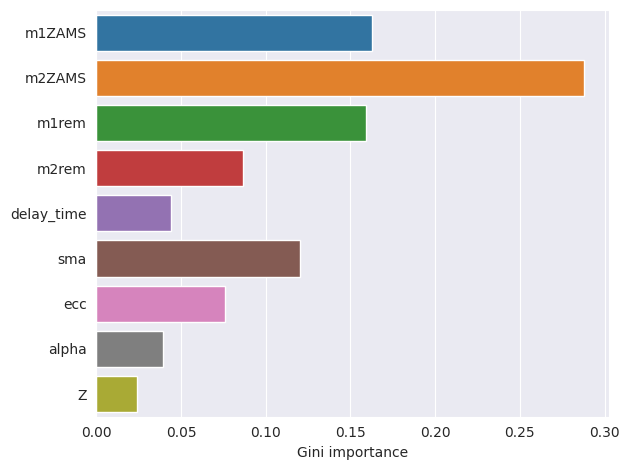

In [22]:
# plot Gini importances
fig, ax = plt.subplots()
sns.barplot(y='param', x='gini', data=importances_reduced, ax=ax, hue='param')
ax.set_ylabel('')
ax.set_xlabel('Gini importance')
fig.tight_layout()
plt.show()

In [23]:
# compute permutation feature importances
# warning: takes a lot of time to compute!
ts = time.time()
result = permutation_importance(clf, X_test[::9], y_test[::9], n_repeats=5, random_state=0, n_jobs=-1)
print("importance calculation time: {:.2f} s".format(time.time() - ts))
# save importances to DataFrame      
importances_reduced['permutation'] = result.importances_mean
importances_reduced['permutation_std'] = result.importances_std

importance calculation time: 26.84 s


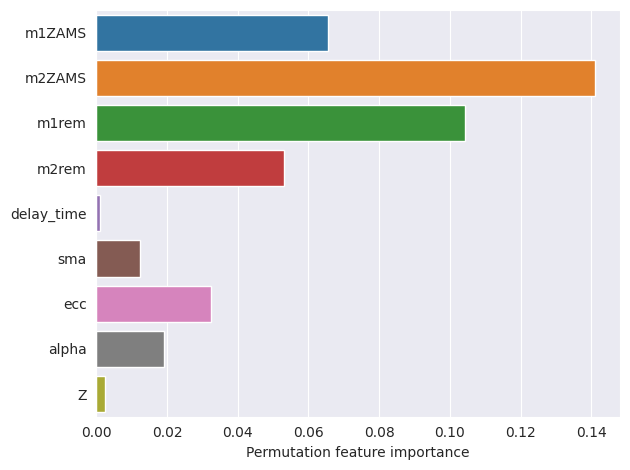

In [24]:
# plot permutation importances
fig, ax = plt.subplots()
sns.barplot(y='param', x='permutation', data=importances_reduced, ax=ax, hue='param')
ax.set_ylabel('')
ax.set_xlabel('Permutation feature importance')
fig.tight_layout()
plt.show()

With the reduced data set, the two importance metrics assign high importances to the mass parameters, with m2ZAMS being deemed the most important. They disagree about the importance of the semimajor axis (sma) and the eccentricity (ecc), but assign low importances to the metallicity Z and the delay time.

In [93]:
corr_red=correlation_df.T[["m1ZAMS", "m2ZAMS", "m1rem", "m2rem", "delay_time", "sma", "ecc", "alpha", "Z"]].T
corr_red


,Correlation
m1ZAMS,-0.462425
m2ZAMS,-0.065608
m1rem,-0.450506
m2rem,-0.306382
delay_time,-0.220924
sma,-0.028308
ecc,0.215878
alpha,-0.010122
Z,-0.035669


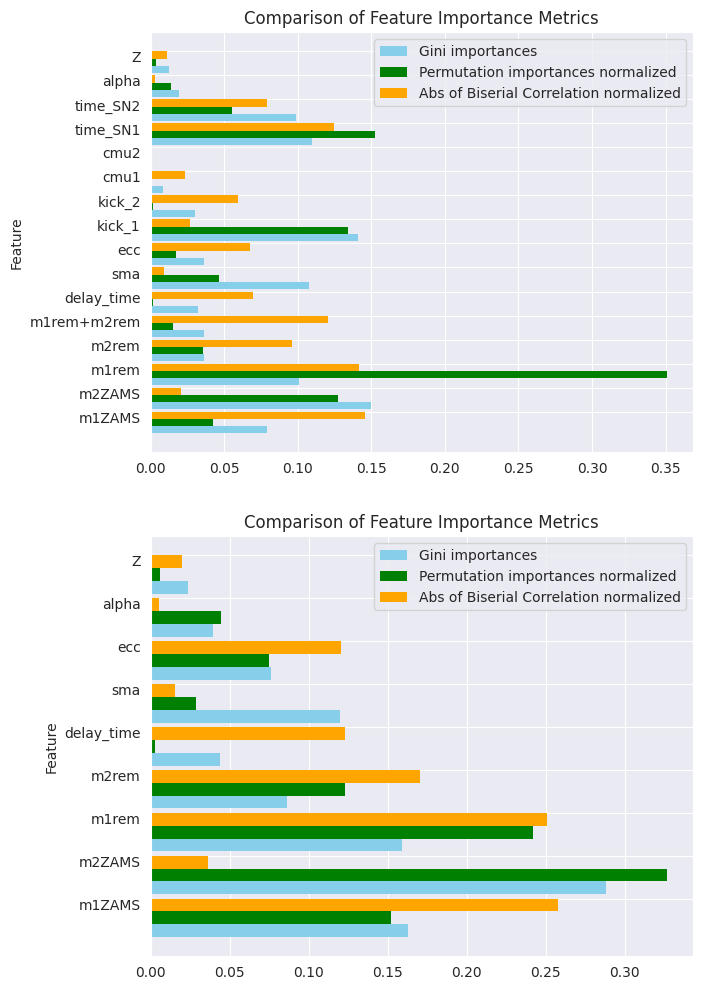

In [126]:
#We show again this graph to compare it with the next one
bar_width = 0.3
fig, ax = plt.subplots(2,1,figsize=(7, 12))

index = np.arange(len(correlation_df))

ax[0].barh(index, importances['gini'], color='skyblue', height=bar_width, label='Gini importances',edgecolor='none')
ax[0].barh(index + bar_width, np.abs(importances['permutation'])/np.abs(importances['permutation']).sum(), color='green', height=bar_width, label='Permutation importances normalized',edgecolor='none')
ax[0].barh(index+2*bar_width, np.abs(correlation_df.iloc[:,0])/np.abs(correlation_df.iloc[:,0]).sum(), color='orange', height=bar_width, label='Abs of Biserial Correlation normalized',edgecolor='none')

ax[0].set_yticks(index+5/2*bar_width)
ax[0].set_yticklabels(correlation_df.index, va='top')

ax[0].set_ylabel('Feature')
ax[0].set_title('Comparison of Feature Importance Metrics')

ax[0].legend()

index_red = np.arange(len(corr_red))

ax[1].barh(index_red, importances_reduced['gini'], color='skyblue', height=bar_width, label='Gini importances',edgecolor='none')
ax[1].barh(index_red + bar_width, np.abs(importances_reduced['permutation'])/np.abs(importances_reduced['permutation']).sum(), color='green', height=bar_width, label='Permutation importances normalized',edgecolor='none')
ax[1].barh(index_red+2*bar_width, np.abs(corr_red['Correlation'])/np.abs(corr_red['Correlation']).sum(), color='orange', height=bar_width, label='Abs of Biserial Correlation normalized',edgecolor='none')

ax[1].set_yticks(index_red+5/2*bar_width)
ax[1].set_yticklabels(corr_red.index, va='top')
ax[1].set_ylabel('Feature')
ax[1].set_title('Comparison of Feature Importance Metrics Using Fewer Features')
ax[1].legend()

plt.show()

## Conclusions

The goal of this project was to understand the importance of the features in distinguishing the evolution of a Binary Black Hole System through Common Envelope versus Mass Transfer. This was done by analyzing their Bisereal Correlation and by applying a Random Forest Classificator that was able to preidct the evolution of the system with a great accuracy (99.84%). After evaluating the Feature Pearmutation IMportance and the Gini Importance, we concluded that the most important features are:
-